In [1]:
# === Passo 0 (VSE++-style, minimale e pulito) ===============================
# - Mappa diretta testo -> visivo
# - Loss: triplet con hard negative (cosine)
# - NIENTE slot, Sinkhorn, ISDL/GDL/DIV, SVD, OneCycleLR/AMP
# - Split a livello immagine + validazione coerente (MRR/R@K/NDCG)
# ============================================================================

import math
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import numpy as np
import hashlib
from scipy import sparse

from challenge.src.common import load_data, prepare_train_data
from challenge.src.eval.metrics import mrr, recall_at_k, ndcg  # <- intoccabili

# ==== Config (semplici, stile VSE++) ========================================
MODEL_PATH = "models/vsepp_text2vis_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 24
BATCH_SIZE = 128
LR_INIT = 2e-4
LR_LATE = 2e-5
LR_STEP_EPOCH = 16
WEIGHT_DECAY = 0.0
MARGIN = 0.20                     # triplet (VSE++)  :contentReference[oaicite:0]{index=0}

# --- Slot supervision (plug-and-play, in-batch multi-neg) ---
K_SLOTS_AUX   = 4                 # pochi slot “locali”, branch solo di training  :contentReference[oaicite:1]{index=1}
TAU_SLOT      = 0.09              # temperatura InfoNCE/CE
LAMBDA_SLOT = 0.15                # peso loss_slot (basso-medio)


# --- Noise injection (solo TRAIN) ---
NOISE_P            = 0.60    # prob. di applicare noise al batch
GAUSS_REL_STD      = 0.015   # std gauss = 1.5% della std per-feature del batch
FEAT_DROP_P        = 0.04    # dropout sparso sulle feature (input-level)
ORTHO_EPS          = 0.02    # intensità micro-rotazione (mix con matrice ortogonale)
NOISE_WARMUP_FRAC  = 0.40    # warmup lineare della forza del noise sui primi 40% delle epoche



def _rand_orthonormal(d: int, device: torch.device):
    # matrice ortogonale via QR da gaussiana
    A = torch.randn(d, d, device=device)
    # QR può dare R con diag negativa: correggiamo il segno per Q
    Q, R = torch.linalg.qr(A, mode='reduced')
    diag_sign = torch.sign(torch.diag(R))
    Q = Q * diag_sign  # broadcast sulle colonne
    return Q           # Q^T Q = I

@torch.no_grad()
def augment_text_embeddings(X: torch.Tensor,
                            p: float,
                            gauss_rel_std: float,
                            feat_drop_p: float,
                            ortho_eps: float,
                            strength: float) -> torch.Tensor:
    """
    X: (B, D_txt) su device
    strength in [0,1]: scala globale (per warmup/anneal)
    """
    if torch.rand(()) > p or strength <= 0.0:
        return X

    B, D = X.shape
    Xn = X

    # 1) Feature-dropout sparso (input-level)
    if feat_drop_p > 0:
        mask = (torch.rand_like(Xn) > feat_drop_p).float()
        # ri-scala per non alterare la norma in media
        Xn = Xn * mask / (1.0 - feat_drop_p)

    # 2) Jitter gaussiano scalato alla std per-feature del batch
    if gauss_rel_std > 0:
        # std per colonna (feature). Evita divisioni per ~0
        col_std = Xn.float().std(dim=0, unbiased=False).clamp_min(1e-8)
        noise = torch.randn_like(Xn) * (gauss_rel_std * col_std)
        Xn = Xn + strength * noise

    # 3) Micro-rotazione quasi-ortogonale (cos-preserving)
    if ortho_eps > 0:
        # costruisci una Q ortogonale piccola (o riusa la stessa per efficienza)
        Q = _rand_orthonormal(D, Xn.device)
        # miscela vicino all'identità: X' ≈ X + eps * (X @ (Q - I))
        I = torch.eye(D, device=Xn.device)
        Xn = Xn + strength * ortho_eps * (Xn @ (Q - I))

    return Xn



# ==== Seed & determinismo ====================================================
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==== Dati ===================================================================
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)   # X: (N_cap, D_txt)  | y: (N_cap, D_img)

img_names_all = train_data['images/names']                                 # (N_img,)
img_emb_all   = torch.from_numpy(train_data['images/embeddings']).float()  # (N_img, D_img)

# --- Split a livello immagine (stabile) ---
val_ratio = 0.10
def stable_hash(name: str) -> float:
    h = hashlib.md5(name.encode('utf-8')).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF

img_hash       = np.array([stable_hash(nm) for nm in img_names_all])
IMG_VAL_MASK   = (img_hash < val_ratio)            # np.bool_
IMG_TRAIN_MASK = ~IMG_VAL_MASK

# Mappa caption → indice globale dell'immagine GT
cap_to_img = train_data['captions/label']
if sparse.issparse(cap_to_img):
    cap_gt_img_idx = cap_to_img.argmax(axis=1).A1
else:
    cap_gt_img_idx = np.argmax(cap_to_img, axis=1)

# Maschere caption coerenti con lo split immagine
CAP_TRAIN_MASK = IMG_TRAIN_MASK[cap_gt_img_idx]
CAP_VAL_MASK   = IMG_VAL_MASK[cap_gt_img_idx]

# Sanity: nessuna immagine in comune tra train e val
assert not (IMG_TRAIN_MASK & IMG_VAL_MASK).any(), "Overlap immagini train/val > 0"

# --- Tensors train/val ---
X_train = X[CAP_TRAIN_MASK]
y_train = y[CAP_TRAIN_MASK]
X_val   = X[CAP_VAL_MASK]
y_val   = y[CAP_VAL_MASK]

print(f"Train captions: {len(X_train):,} | Val captions: {len(X_val):,}")
print(f"Train images  : {int(IMG_TRAIN_MASK.sum()):,} | Val images  : {int(IMG_VAL_MASK.sum()):,}")

# --- DataLoader ---
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          pin_memory=(DEVICE.type=='cuda'))
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          pin_memory=(DEVICE.type=='cuda'))

# --- Gallery VALIDAZIONE (immagini di val, normalizzate) ---
val_img_embd = F.normalize(img_emb_all[torch.from_numpy(IMG_VAL_MASK)], dim=-1).cpu()  # (N_img_val, D)
val_img_file = img_names_all[IMG_VAL_MASK]

# Rimappa GT caption→indice compatto della gallery val
global_to_val = -np.ones(len(img_names_all), dtype=np.int64)
global_to_val[np.where(IMG_VAL_MASK)[0]] = np.arange(IMG_VAL_MASK.sum(), dtype=np.int64)
val_gt_global = cap_gt_img_idx[CAP_VAL_MASK]
val_label = global_to_val[val_gt_global].astype(np.int64)   # (Nq,)

# ==== Modello minimale: Text -> Vis (VSE++-style) ============================
class TextToVis(nn.Module):
    def __init__(self, d_text=1024, d_vis=1536, hidden=2048):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(d_text, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_vis, bias=True)
        )
    def forward(self, t):
        z = self.proj(t)
        return F.normalize(z, dim=-1)  # vettore globale Z (cos-ready)

class SlotAuxHead(nn.Module):
    """ Head ausiliaria: produce K vettori 'locali' per InfoNCE per-slot (solo in training). """
    def __init__(self, d_text=1024, d_vis=1536, K=4, hidden=1024):
        super().__init__()
        self.K = K
        self.ff = nn.Sequential(
            nn.Linear(d_text, hidden), nn.GELU(),
            nn.Linear(hidden, K * d_vis, bias=True)
        )
        self.d_vis = d_vis
    def forward(self, t):
        B = t.size(0)
        S = self.ff(t).view(B, self.K, self.d_vis)   # (B,K,D)
        return F.normalize(S, dim=-1)

model     = TextToVis(d_text=X.shape[1], d_vis=y.shape[1], hidden=2048).to(DEVICE)
slot_head = SlotAuxHead(d_text=X.shape[1], d_vis=y.shape[1], K=K_SLOTS_AUX, hidden=1024).to(DEVICE)


# ==== Loss: triplet con hard negative (cosine) ===============================
def triplet_hard_neg_cos(Z, Y, margin):
    S = Z @ Y.t()
    pos = S.diag()
    B = S.size(0)
    S = S.clone(); S[torch.arange(B), torch.arange(B)] = float('-inf')
    neg = S.max(dim=1).values
    return F.relu(margin + neg - pos).mean()        # VSE++ hard negatives  :contentReference[oaicite:6]{index=6}

def loss_slot_ce(S_T, Y, tau=0.07):
    """
    CE/InfoNCE per-slot con negativi in-batch.
    S_T: (B,K,D) slot testuali normalizzati; Y: (B,D) immagini normalizzate.
    """
    B, K, D = S_T.shape
    Yt = Y.t()                                 # (D,B)
    losses = []
    target = torch.arange(B, device=S_T.device)
    for k in range(K):
        logits = (S_T[:, k, :] @ Yt) / tau     # (B,B)
        losses.append(F.cross_entropy(logits, target))
    return torch.stack(losses).mean()          # media sui K slot  

# --- Hinge regularizers (def. OFF; pronti se vorrai riattivarli) ---
def isdl_hinge(S_T, delta=0.55):
    """Penalizza solo sim intra-slot > δ (diversità utile preservata)."""
    B, K, D = S_T.shape
    if K <= 1:
        return S_T.new_zeros(())
    C = (S_T @ S_T.transpose(1, 2)).clamp(-1, 1)            # (B,K,K)
    mask = ~torch.eye(K, device=S_T.device, dtype=torch.bool)  # (K,K)
    C_off = C[:, mask].view(B, -1)                          # (B, K*(K-1))
    return F.relu(C_off - delta).mean()


def gdl_hinge(S_T, Z, delta=0.60):
    """ Penalizza slot troppo allineati al globale (solo se serve). """
    sims = torch.einsum('bkd,bd->bk', S_T, Z).clamp(-1,1)  # (B,K)
    return F.relu(sims - delta).mean()

# --- Angular constraint leggero sui positivi ---
def loss_ang(Z, Y, target=0.35):
    cos_pos = torch.sum(Z * Y, dim=1)                      # (B,)
    return F.relu(target - cos_pos).mean()                 # spinge cos_pos ≥ target  :contentReference[oaicite:8]{index=8}

# ==== Helper: MRR/R@K/NDCG su gallery globale di validazione =================
@torch.no_grad()
def evaluate_retrieval_global(Z: torch.Tensor,
                              gallery: torch.Tensor,
                              gt_indices: np.ndarray,
                              topk: int = 100,
                              chunk: int = 512):
    Z = Z.to('cpu'); gallery = gallery.to('cpu')
    Nq, Ng = Z.size(0), gallery.size(0)
    topk = min(topk, Ng)

    all_topk = []
    for start in range(0, Nq, chunk):
        end = min(start + chunk, Nq)
        sims = Z[start:end] @ gallery.T
        topk_idx = torch.topk(sims, k=topk, dim=1, largest=True, sorted=True).indices
        all_topk.append(topk_idx.cpu().numpy())
    pred_indices = np.vstack(all_topk).astype(np.int64)

    l2_dist = (Z - gallery[torch.from_numpy(gt_indices)]).norm(dim=1).mean().item()
    return {
        'mrr': mrr(pred_indices, gt_indices),
        'ndcg': ndcg(pred_indices, gt_indices),
        'recall_at_1':  recall_at_k(pred_indices, gt_indices, 1),
        'recall_at_3':  recall_at_k(pred_indices, gt_indices, 3),
        'recall_at_5':  recall_at_k(pred_indices, gt_indices, 5),
        'recall_at_10': recall_at_k(pred_indices, gt_indices, 10),
        'recall_at_50': recall_at_k(pred_indices, gt_indices, 50),
        'l2_dist': l2_dist,
    }

# ==== Diagnostica: margine rapido su un batch di val =========================
@torch.no_grad()
def quick_margin_on_val_batch(model, val_dataset, device):
    loader = DataLoader(val_dataset, batch_size=min(512, len(val_dataset)), shuffle=True)
    Xb, Yb = next(iter(loader))
    Xb, Yb = Xb.to(device), F.normalize(Yb.to(device), dim=-1)
    Z = model(Xb)                # (B, D)
    S = Z @ Yb.T                 # (B, B)
    pos = S.diag()
    B = S.size(0)
    S[torch.arange(B), torch.arange(B)] = float('-inf')
    neg = S.max(dim=1).values
    return (pos - neg).mean().item(), pos.mean().item(), neg.mean().item()

# ==== Training (semplice, con step LR a metà) ================================
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int) -> nn.Module:

    opt = torch.optim.Adam(list(model.parameters()) + list(slot_head.parameters()), lr=LR_INIT, weight_decay=WEIGHT_DECAY)
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS * steps_per_epoch, eta_min=LR_LATE)
    best_mrr = -1.0
    ckpt_dir = Path(MODEL_PATH).parent / "checkpoints_vsepp"
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # step LR a metà, stile VSE++
        if epoch == LR_STEP_EPOCH:
            for g in opt.param_groups:
                g['lr'] = LR_LATE

        model.train()
        running_loss = 0.0
        for Xb, Yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{epochs}"):
            Xb = Xb.to(device, non_blocking=True)
            Yb = F.normalize(Yb.to(device, non_blocking=True), dim=-1)

            Zb = model(Xb)                  # (B,D) globale (inference-ready)
            Sb = slot_head(Xb)              # (B,K,D) ausiliario (solo training)

            loss_tri  = triplet_hard_neg_cos(Zb, Yb, margin=MARGIN)
            loss_slot = loss_slot_ce(Sb, Yb, tau=TAU_SLOT)         # multi-neg in-batch


            loss = loss_tri + LAMBDA_SLOT * loss_slot

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(slot_head.parameters()), 1.0)
            opt.step()
            scheduler.step()
            if epoch % 5 == 0:
                with torch.no_grad():
                    W = model.proj[-1].weight  # ultimo Linear nel mapping
                    U, _, Vt = torch.linalg.svd(W, full_matrices=False)
                    model.proj[-1].weight.copy_(U @ Vt)

            running_loss += float(loss.item())

        train_loss = running_loss / max(1, len(train_loader))

        # --- validazione: cos medio (proxy) + MRR/R@K su gallery globale ---
        model.eval()

        # Quick proxy: media cos(Z, Y) sui batch val (non è la metrica finale)
        val_cos_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for Xb, Yb in DataLoader(val_loader.dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                Yb = F.normalize(Yb.to(device, non_blocking=True), dim=-1)
                Zb = model(Xb)
                cos_b = torch.einsum('bd,bd->b', Zb, Yb).mean()
                val_cos_sum += float(cos_b.item())
                val_batches += 1
        val_cos = val_cos_sum / max(val_batches, 1)

        # Embed TUTTE le caption di val e valuta retrieval su gallery immagini di val
        preds_val = []
        with torch.no_grad():
            for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                preds_val.append(model(Xb).cpu())
        Z_val = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

        res_val = evaluate_retrieval_global(Z_val, val_img_embd, val_label, topk=100, chunk=512)
        curr_mrr = res_val['mrr']

        print(f"\n[Val] loss={train_loss:.4f} | z_cos={val_cos:.4f}")
        print(f"      mrr={res_val['mrr']:.4f} | ndcg={res_val['ndcg']:.4f} | "
            f"R@1={res_val['recall_at_1']:.4f} | R@5={res_val['recall_at_5']:.4f} | "
            f"R@10={res_val['recall_at_10']:.4f} | L2={res_val['l2_dist']:.4f}")
        q_margin, q_pos, q_neg = quick_margin_on_val_batch(model, val_dataset, DEVICE)
        print(f"      quick_margin={q_margin:.4f} | s_pos={q_pos:.4f} | s_neg*={q_neg:.4f}")
        print(f"      losses: tri={float(loss_tri.item()):.4f} | slot={float(loss_slot.item()):.4f} ")
        # --- salvataggio per epoca + best per MRR ---
        ckpt_path = ckpt_dir / f"epoch_{epoch:03d}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ☐ Saved {ckpt_path.name}")

        if curr_mrr > best_mrr:
            best_mrr = curr_mrr
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✅ New best MRR ({best_mrr:.5f}) → saved {Path(MODEL_PATH).name}")

    print(f"\n=== Training finito. Best MRR val: {best_mrr:.5f} | checkpoint: {MODEL_PATH}")
    return model

# ==== Avvio training =========================================================
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=EPOCHS,
)


(125000,)
Train data: 125000 captions, 125000 images
Train captions: 112,420 | Val captions: 12,580
Train images  : 22,484 | Val images  : 2,516


[Train] Epoch 1/24: 100%|██████████| 879/879 [00:13<00:00, 63.46it/s]



[Val] loss=0.5396 | z_cos=0.2554
      mrr=0.4262 | ndcg=0.5379 | R@1=0.2902 | R@5=0.5865 | R@10=0.7162 | L2=1.2190
      quick_margin=0.0004 | s_pos=0.2554 | s_neg*=0.2550
      losses: tri=0.1240 | slot=1.2207 
  ☐ Saved epoch_001.pth
  ✅ New best MRR (0.42621) → saved vsepp_text2vis_best.pth


[Train] Epoch 2/24: 100%|██████████| 879/879 [00:13<00:00, 67.03it/s]



[Val] loss=0.4551 | z_cos=0.2632
      mrr=0.4478 | ndcg=0.5572 | R@1=0.3076 | R@5=0.6123 | R@10=0.7427 | L2=1.2124
      quick_margin=0.0019 | s_pos=0.2672 | s_neg*=0.2652
      losses: tri=0.0905 | slot=0.9099 
  ☐ Saved epoch_002.pth
  ✅ New best MRR (0.44780) → saved vsepp_text2vis_best.pth


[Train] Epoch 3/24: 100%|██████████| 879/879 [00:13<00:00, 65.93it/s]



[Val] loss=0.4222 | z_cos=0.2648
      mrr=0.4538 | ndcg=0.5623 | R@1=0.3123 | R@5=0.6211 | R@10=0.7465 | L2=1.2110
      quick_margin=-0.0013 | s_pos=0.2622 | s_neg*=0.2635
      losses: tri=0.0738 | slot=0.8030 
  ☐ Saved epoch_003.pth
  ✅ New best MRR (0.45381) → saved vsepp_text2vis_best.pth


[Train] Epoch 4/24: 100%|██████████| 879/879 [00:13<00:00, 63.97it/s]



[Val] loss=0.4001 | z_cos=0.2608
      mrr=0.4554 | ndcg=0.5628 | R@1=0.3165 | R@5=0.6223 | R@10=0.7428 | L2=1.2142
      quick_margin=0.0042 | s_pos=0.2588 | s_neg*=0.2546
      losses: tri=0.0527 | slot=0.6945 
  ☐ Saved epoch_004.pth
  ✅ New best MRR (0.45535) → saved vsepp_text2vis_best.pth


[Train] Epoch 5/24: 100%|██████████| 879/879 [06:13<00:00,  2.36it/s]



[Val] loss=0.3955 | z_cos=0.2216
      mrr=0.4624 | ndcg=0.5700 | R@1=0.3221 | R@5=0.6357 | R@10=0.7548 | L2=1.2464
      quick_margin=0.0051 | s_pos=0.2238 | s_neg*=0.2188
      losses: tri=0.0868 | slot=0.7489 
  ☐ Saved epoch_005.pth
  ✅ New best MRR (0.46236) → saved vsepp_text2vis_best.pth


[Train] Epoch 6/24: 100%|██████████| 879/879 [00:13<00:00, 63.46it/s]



[Val] loss=0.3800 | z_cos=0.2490
      mrr=0.4658 | ndcg=0.5718 | R@1=0.3258 | R@5=0.6329 | R@10=0.7507 | L2=1.2240
      quick_margin=0.0038 | s_pos=0.2479 | s_neg*=0.2441
      losses: tri=0.0554 | slot=0.7272 
  ☐ Saved epoch_006.pth
  ✅ New best MRR (0.46580) → saved vsepp_text2vis_best.pth


[Train] Epoch 7/24: 100%|██████████| 879/879 [00:13<00:00, 67.05it/s]



[Val] loss=0.3658 | z_cos=0.2531
      mrr=0.4642 | ndcg=0.5701 | R@1=0.3234 | R@5=0.6347 | R@10=0.7518 | L2=1.2206
      quick_margin=0.0124 | s_pos=0.2551 | s_neg*=0.2428
      losses: tri=0.0602 | slot=0.7575 
  ☐ Saved epoch_007.pth


[Train] Epoch 8/24: 100%|██████████| 879/879 [00:13<00:00, 64.82it/s]



[Val] loss=0.3548 | z_cos=0.2528
      mrr=0.4663 | ndcg=0.5714 | R@1=0.3271 | R@5=0.6376 | R@10=0.7506 | L2=1.2207
      quick_margin=0.0092 | s_pos=0.2542 | s_neg*=0.2450
      losses: tri=0.0640 | slot=0.8633 
  ☐ Saved epoch_008.pth
  ✅ New best MRR (0.46628) → saved vsepp_text2vis_best.pth


[Train] Epoch 9/24: 100%|██████████| 879/879 [00:12<00:00, 68.24it/s]



[Val] loss=0.3453 | z_cos=0.2473
      mrr=0.4633 | ndcg=0.5680 | R@1=0.3250 | R@5=0.6311 | R@10=0.7459 | L2=1.2252
      quick_margin=0.0019 | s_pos=0.2469 | s_neg*=0.2450
      losses: tri=0.0717 | slot=0.8958 
  ☐ Saved epoch_009.pth


[Train] Epoch 10/24: 100%|██████████| 879/879 [06:22<00:00,  2.30it/s]



[Val] loss=0.3524 | z_cos=0.2189
      mrr=0.4747 | ndcg=0.5802 | R@1=0.3339 | R@5=0.6473 | R@10=0.7631 | L2=1.2486
      quick_margin=0.0110 | s_pos=0.2177 | s_neg*=0.2067
      losses: tri=0.0566 | slot=0.7282 
  ☐ Saved epoch_010.pth
  ✅ New best MRR (0.47465) → saved vsepp_text2vis_best.pth


[Train] Epoch 11/24: 100%|██████████| 879/879 [00:13<00:00, 66.24it/s]



[Val] loss=0.3431 | z_cos=0.2360
      mrr=0.4707 | ndcg=0.5757 | R@1=0.3308 | R@5=0.6410 | R@10=0.7560 | L2=1.2345
      quick_margin=0.0069 | s_pos=0.2332 | s_neg*=0.2264
      losses: tri=0.0777 | slot=0.7828 
  ☐ Saved epoch_011.pth


[Train] Epoch 12/24: 100%|██████████| 879/879 [00:12<00:00, 71.49it/s]



[Val] loss=0.3329 | z_cos=0.2457
      mrr=0.4698 | ndcg=0.5743 | R@1=0.3303 | R@5=0.6422 | R@10=0.7533 | L2=1.2266
      quick_margin=0.0047 | s_pos=0.2415 | s_neg*=0.2368
      losses: tri=0.0632 | slot=0.7237 
  ☐ Saved epoch_012.pth


[Train] Epoch 13/24: 100%|██████████| 879/879 [00:13<00:00, 66.14it/s]



[Val] loss=0.3256 | z_cos=0.2477
      mrr=0.4702 | ndcg=0.5741 | R@1=0.3301 | R@5=0.6400 | R@10=0.7521 | L2=1.2250
      quick_margin=0.0074 | s_pos=0.2446 | s_neg*=0.2372
      losses: tri=0.0715 | slot=0.8887 
  ☐ Saved epoch_013.pth


[Train] Epoch 14/24: 100%|██████████| 879/879 [00:12<00:00, 71.94it/s]



[Val] loss=0.3186 | z_cos=0.2478
      mrr=0.4646 | ndcg=0.5689 | R@1=0.3253 | R@5=0.6354 | R@10=0.7456 | L2=1.2247
      quick_margin=0.0029 | s_pos=0.2437 | s_neg*=0.2408
      losses: tri=0.0751 | slot=0.8333 
  ☐ Saved epoch_014.pth


[Train] Epoch 15/24: 100%|██████████| 879/879 [06:22<00:00,  2.30it/s]



[Val] loss=0.3288 | z_cos=0.2146
      mrr=0.4800 | ndcg=0.5845 | R@1=0.3385 | R@5=0.6531 | R@10=0.7676 | L2=1.2520
      quick_margin=0.0096 | s_pos=0.2134 | s_neg*=0.2037
      losses: tri=0.0645 | slot=0.6833 
  ☐ Saved epoch_015.pth
  ✅ New best MRR (0.47999) → saved vsepp_text2vis_best.pth


[Train] Epoch 16/24: 100%|██████████| 879/879 [00:14<00:00, 62.72it/s]



[Val] loss=0.3177 | z_cos=0.2233
      mrr=0.4841 | ndcg=0.5878 | R@1=0.3429 | R@5=0.6578 | R@10=0.7706 | L2=1.2450
      quick_margin=0.0113 | s_pos=0.2266 | s_neg*=0.2153
      losses: tri=0.0825 | slot=0.7238 
  ☐ Saved epoch_016.pth
  ✅ New best MRR (0.48411) → saved vsepp_text2vis_best.pth


[Train] Epoch 17/24: 100%|██████████| 879/879 [00:14<00:00, 62.56it/s]



[Val] loss=0.3145 | z_cos=0.2254
      mrr=0.4832 | ndcg=0.5869 | R@1=0.3419 | R@5=0.6583 | R@10=0.7684 | L2=1.2432
      quick_margin=0.0062 | s_pos=0.2221 | s_neg*=0.2160
      losses: tri=0.0713 | slot=0.7215 
  ☐ Saved epoch_017.pth


[Train] Epoch 18/24: 100%|██████████| 879/879 [00:12<00:00, 68.71it/s]



[Val] loss=0.3120 | z_cos=0.2303
      mrr=0.4835 | ndcg=0.5869 | R@1=0.3432 | R@5=0.6554 | R@10=0.7675 | L2=1.2392
      quick_margin=0.0108 | s_pos=0.2297 | s_neg*=0.2190
      losses: tri=0.0630 | slot=0.7042 
  ☐ Saved epoch_018.pth


[Train] Epoch 19/24: 100%|██████████| 879/879 [00:12<00:00, 71.03it/s]



[Val] loss=0.3100 | z_cos=0.2307
      mrr=0.4807 | ndcg=0.5845 | R@1=0.3386 | R@5=0.6543 | R@10=0.7661 | L2=1.2388
      quick_margin=0.0096 | s_pos=0.2318 | s_neg*=0.2222
      losses: tri=0.0755 | slot=0.8225 
  ☐ Saved epoch_019.pth


[Train] Epoch 20/24: 100%|██████████| 879/879 [06:20<00:00,  2.31it/s]



[Val] loss=0.3151 | z_cos=0.2137
      mrr=0.4836 | ndcg=0.5878 | R@1=0.3417 | R@5=0.6575 | R@10=0.7738 | L2=1.2527
      quick_margin=0.0118 | s_pos=0.2136 | s_neg*=0.2018
      losses: tri=0.0585 | slot=0.6894 
  ☐ Saved epoch_020.pth


[Train] Epoch 21/24: 100%|██████████| 879/879 [00:16<00:00, 53.29it/s]



[Val] loss=0.3132 | z_cos=0.2223
      mrr=0.4849 | ndcg=0.5885 | R@1=0.3438 | R@5=0.6587 | R@10=0.7723 | L2=1.2457
      quick_margin=0.0106 | s_pos=0.2220 | s_neg*=0.2113
      losses: tri=0.0558 | slot=0.6319 
  ☐ Saved epoch_021.pth
  ✅ New best MRR (0.48485) → saved vsepp_text2vis_best.pth


[Train] Epoch 22/24: 100%|██████████| 879/879 [00:15<00:00, 57.79it/s]



[Val] loss=0.3108 | z_cos=0.2275
      mrr=0.4851 | ndcg=0.5884 | R@1=0.3442 | R@5=0.6583 | R@10=0.7707 | L2=1.2415
      quick_margin=0.0093 | s_pos=0.2325 | s_neg*=0.2231
      losses: tri=0.0589 | slot=0.5948 
  ☐ Saved epoch_022.pth
  ✅ New best MRR (0.48513) → saved vsepp_text2vis_best.pth


[Train] Epoch 23/24: 100%|██████████| 879/879 [00:13<00:00, 65.48it/s]



[Val] loss=0.3087 | z_cos=0.2287
      mrr=0.4831 | ndcg=0.5867 | R@1=0.3421 | R@5=0.6559 | R@10=0.7674 | L2=1.2405
      quick_margin=0.0094 | s_pos=0.2329 | s_neg*=0.2235
      losses: tri=0.0624 | slot=0.7272 
  ☐ Saved epoch_023.pth


[Train] Epoch 24/24: 100%|██████████| 879/879 [00:12<00:00, 70.43it/s]



[Val] loss=0.3067 | z_cos=0.2294
      mrr=0.4814 | ndcg=0.5850 | R@1=0.3409 | R@5=0.6543 | R@10=0.7671 | L2=1.2399
      quick_margin=0.0118 | s_pos=0.2322 | s_neg*=0.2204
      losses: tri=0.0565 | slot=0.5750 
  ☐ Saved epoch_024.pth

=== Training finito. Best MRR val: 0.48513 | checkpoint: models/vsepp_text2vis_best.pth


[Eval] Val captions: 12,580 | Val images: 2,516
epoch_001.pth   → MRR=0.42621
epoch_002.pth   → MRR=0.44780
epoch_003.pth   → MRR=0.45381
epoch_004.pth   → MRR=0.45535
epoch_005.pth   → MRR=0.46236
epoch_006.pth   → MRR=0.46580
epoch_007.pth   → MRR=0.46422
epoch_008.pth   → MRR=0.46628
epoch_009.pth   → MRR=0.46325
epoch_010.pth   → MRR=0.47465
epoch_011.pth   → MRR=0.47066
epoch_012.pth   → MRR=0.46982
epoch_013.pth   → MRR=0.47017
epoch_014.pth   → MRR=0.46461
epoch_015.pth   → MRR=0.47999
epoch_016.pth   → MRR=0.48411
epoch_017.pth   → MRR=0.48321
epoch_018.pth   → MRR=0.48354
epoch_019.pth   → MRR=0.48075
epoch_020.pth   → MRR=0.48361
epoch_021.pth   → MRR=0.48485
epoch_022.pth   → MRR=0.48513
epoch_023.pth   → MRR=0.48314
epoch_024.pth   → MRR=0.48145

=== Miglior checkpoint (MRR su val-gallery) ===
epoch_022.pth → MRR=0.48513

=== Val (image-level split, global gallery) — BEST CKPT ===
mrr            : 0.4851
ndcg           : 0.5884
recall_at_1    : 0.3442
recall_at_3    : 0.557

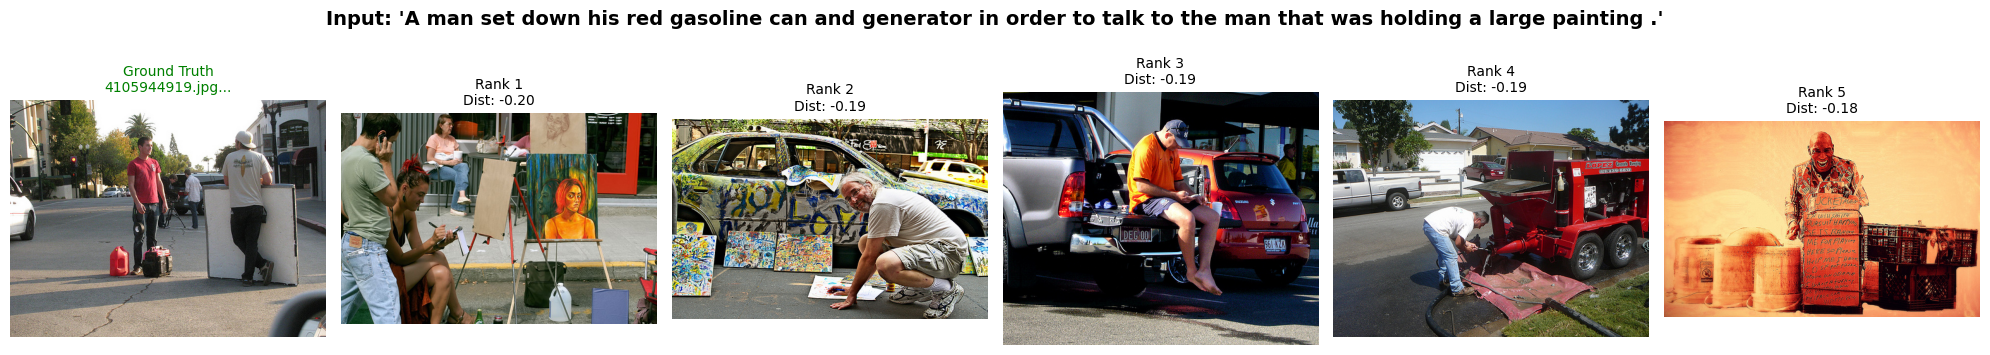

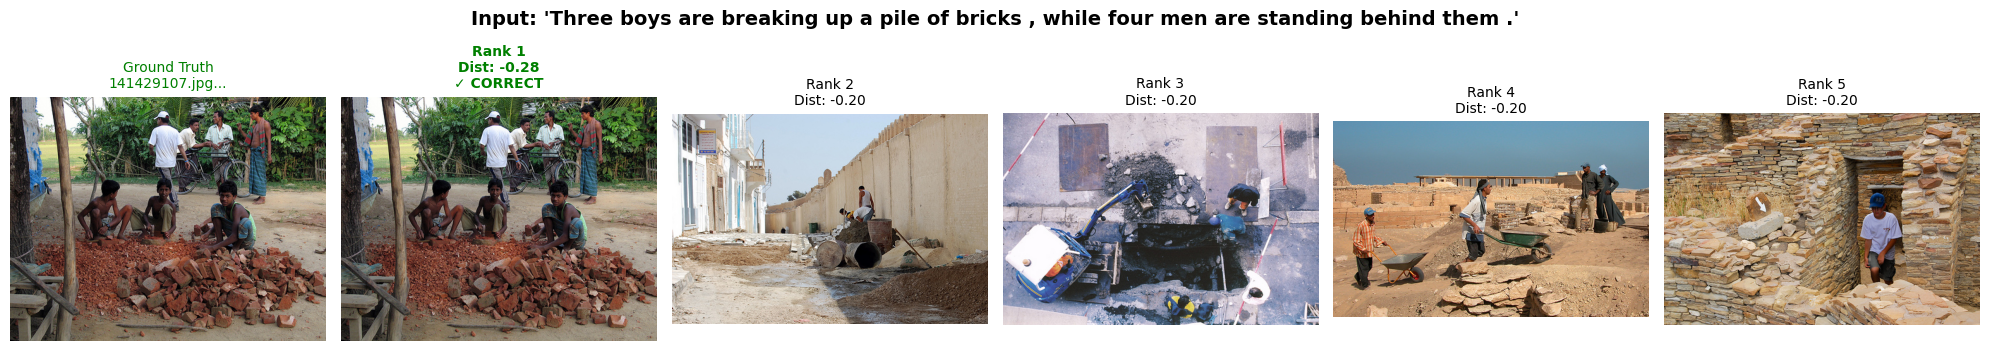

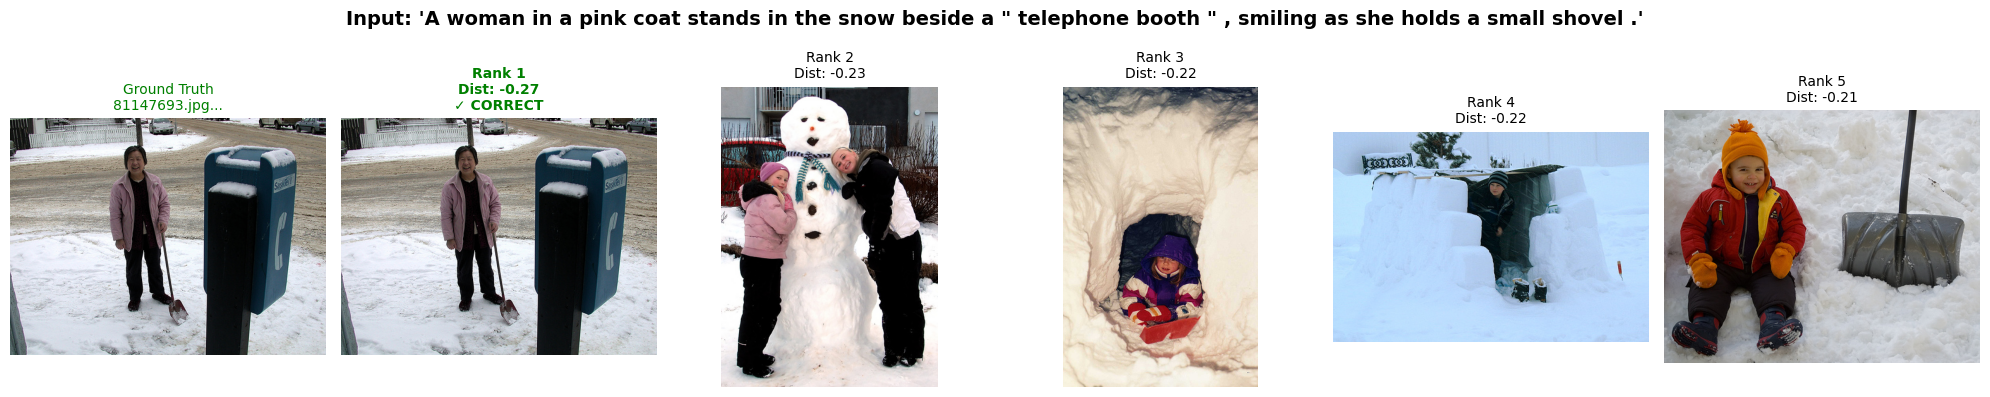


[Ready] BEST_CHECKPOINT_FOR_SUBMIT = epoch_022.pth


In [2]:
# ===========================
# Valutazione: seleziona il best checkpoint per MRR (val gallery)
# ===========================
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from challenge.src.eval.visualize import visualize_retrieval
from challenge.src.eval.metrics import mrr, ndcg, recall_at_k  # intoccabili
import os
torch.manual_seed(int.from_bytes(os.urandom(4), "little"))
model.eval()

# ===========================
# Split COERENTE per IMMAGINI (stesso hashing del train)
# ===========================
import hashlib
from scipy import sparse

img_names_all = train_data['images/names']                                  # (N_img,)
img_emb_all   = torch.from_numpy(train_data['images/embeddings']).float()   # (N_img, D_img)

val_ratio = 0.10
def stable_hash(name: str) -> float:
    h = hashlib.md5(name.encode('utf-8')).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF

img_hash       = np.array([stable_hash(nm) for nm in img_names_all])
IMG_VAL_MASK   = (img_hash < val_ratio)
IMG_TRAIN_MASK = ~IMG_VAL_MASK
assert not (IMG_VAL_MASK & IMG_TRAIN_MASK).any(), "Overlap immagini train/val > 0"

# Caption → indice globale immagine GT
cap_to_img = train_data['captions/label']
if sparse.issparse(cap_to_img):
    cap_gt_img_idx = cap_to_img.argmax(axis=1).A1
else:
    cap_gt_img_idx = np.argmax(cap_to_img, axis=1)

CAP_TRAIN_MASK = IMG_TRAIN_MASK[cap_gt_img_idx]
CAP_VAL_MASK   = IMG_VAL_MASK[cap_gt_img_idx]

# Tensors val
X_val = X[CAP_VAL_MASK]
y_val = y[CAP_VAL_MASK]
val_dataset = TensorDataset(X_val, y_val)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=(DEVICE.type=='cuda'))

print(f"[Eval] Val captions: {len(X_val):,} | Val images: {int(IMG_VAL_MASK.sum()):,}")

# Gallery VALIDAZIONE (solo immagini di val, normalizzate)
val_img_embd = F.normalize(img_emb_all[torch.from_numpy(IMG_VAL_MASK)], dim=-1).cpu()  # (N_img_val, D)
val_img_file = img_names_all[IMG_VAL_MASK]

# Rimappa GT caption→indice compatto della gallery val
global_to_val = -np.ones(len(img_names_all), dtype=np.int64)
global_to_val[np.where(IMG_VAL_MASK)[0]] = np.arange(IMG_VAL_MASK.sum(), dtype=np.int64)
val_gt_global = cap_gt_img_idx[CAP_VAL_MASK]
val_label = global_to_val[val_gt_global]   # (Nq,)

# ============================================================
# Helper: calcolo metriche retrieval su gallery completa
# ============================================================
@torch.no_grad()
def evaluate_retrieval_global(Z: torch.Tensor,
                              gallery: torch.Tensor,
                              gt_indices: np.ndarray,
                              topk: int = 100,
                              chunk: int = 512):
    Z = Z.to('cpu'); gallery = gallery.to('cpu')
    Nq, Ng = Z.size(0), gallery.size(0)
    topk = min(topk, Ng)

    all_topk = []
    for start in range(0, Nq, chunk):
        end = min(start + chunk, Nq)
        sims = Z[start:end] @ gallery.T
        topk_idx = torch.topk(sims, k=topk, dim=1, largest=True, sorted=True).indices
        all_topk.append(topk_idx.cpu().numpy())
    pred_indices = np.vstack(all_topk).astype(np.int64)

    l2_dist = (Z - gallery[torch.from_numpy(gt_indices)]).norm(dim=1).mean().item()
    return {
        'mrr': mrr(pred_indices, gt_indices),
        'ndcg': ndcg(pred_indices, gt_indices),
        'recall_at_1':  recall_at_k(pred_indices, gt_indices, 1),
        'recall_at_3':  recall_at_k(pred_indices, gt_indices, 3),
        'recall_at_5':  recall_at_k(pred_indices, gt_indices, 5),
        'recall_at_10': recall_at_k(pred_indices, gt_indices, 10),
        'recall_at_50': recall_at_k(pred_indices, gt_indices, 50),
        'l2_dist': l2_dist,
    }

# ============================================================
# Scan dei checkpoint → selezione BEST per MRR (stessa val-gallery)
# ============================================================
ckpt_dir = Path(MODEL_PATH).parent / "checkpoints_vsepp"
checkpoints = sorted(ckpt_dir.glob("epoch_*.pth"))
assert len(checkpoints) > 0, f"Nessun checkpoint trovato in {ckpt_dir}"

results = []
with torch.no_grad():
    for ckpt_path in checkpoints:
        state = torch.load(ckpt_path, map_location=DEVICE)
        model.load_state_dict(state)
        model.eval()

        preds_val = []
        for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
            Xb = Xb.to(DEVICE, non_blocking=True)
            Eb = model(Xb)                    # (B,D) — coerente col train
            preds_val.append(Eb.cpu())
        Z_val = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

        sims = Z_val @ val_img_embd.T
        topk_idx = torch.topk(sims, k=min(100, val_img_embd.size(0)), dim=1, largest=True, sorted=True).indices.numpy()
        mrr_val = mrr(topk_idx, val_label)

        results.append((ckpt_path.name, float(mrr_val)))
        print(f"{ckpt_path.name:15s} → MRR={mrr_val:.5f}")

best_ckpt_name, best_mrr = max(results, key=lambda x: x[1])
print("\n=== Miglior checkpoint (MRR su val-gallery) ===")
print(f"{best_ckpt_name} → MRR={best_mrr:.5f}")

# Carica il best nel modello e stampa le metriche complete
best_state = torch.load(ckpt_dir / best_ckpt_name, map_location=DEVICE)
model.load_state_dict(best_state)
model.eval()

preds_val = []
with torch.no_grad():
    for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE, non_blocking=True)
        Eb = model(Xb)                    # coerente
        preds_val.append(Eb.cpu())
Z_val_best = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

res_val = evaluate_retrieval_global(Z_val_best, val_img_embd, val_label, topk=100, chunk=512)
print("\n=== Val (image-level split, global gallery) — BEST CKPT ===")
for k, v in res_val.items():
    print(f"{k:15s}: {v:.4f}")

# (Facoltativo) Esplora retrieval qualitativo su 3 esempi
for _ in range(3):
    i = np.random.randint(0, len(X_val))
    with torch.no_grad():
        zb = model(X_val[i:i+1].to(DEVICE)).cpu()   # coerente
    caption_text = train_data['captions/text'][CAP_VAL_MASK][i]
    gt_idx = int(val_label[i])
    visualize_retrieval(zb, gt_idx, val_img_file, caption_text, val_img_embd, k=5)

# Mantieni in memoria per la submission:
BEST_CHECKPOINT_FOR_SUBMIT = best_ckpt_name
print(f"\n[Ready] BEST_CHECKPOINT_FOR_SUBMIT = {BEST_CHECKPOINT_FOR_SUBMIT}")


In [5]:
# === Submission (coerente con la validazione) ===============================
from challenge.src.common import load_data, generate_submission

best_state = torch.load(MODEL_PATH, map_location=DEVICE)
submit_model = TextToVis(d_text=X.shape[1], d_vis=y.shape[1], hidden=2048).to(DEVICE)
submit_model.load_state_dict(best_state)
submit_model.eval()

test = load_data("data/test/test.clean.npz")
test_ids = test['captions/ids']
test_emb = torch.from_numpy(test['captions/embeddings']).float()

pred_chunks = []
with torch.inference_mode():
    for Xb in DataLoader(test_emb, batch_size=BATCH_SIZE, shuffle=False,
                         pin_memory=(DEVICE.type=='cuda')):
        Xb = Xb.to(DEVICE, non_blocking=True)
        Zb = submit_model(Xb)
        pred_chunks.append(Zb.cpu().to(torch.float32))
pred_test = torch.cat(pred_chunks, dim=0)

assert pred_test.shape[0] == len(test_ids)
assert pred_test.shape[1] == y.shape[1], f"{pred_test.shape[1]} != {y.shape[1]} (D_img)"
generate_submission(test_ids, pred_test, "submission.csv")
print("✓ Submission pronta: submission.csv")


Generating submission file...
✓ Saved submission to submission.csv
✓ Submission pronta: submission.csv
